In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

ModuleNotFoundError: No module named 'epftoolbox'

# LEAR

In [2]:
df = pd.read_csv(r"Data\EPFToolbox\FR.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)

In [4]:
df.index = df.Date

In [5]:
df = df.drop('Date', axis = 1)

In [8]:
df.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [9]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [10]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [11]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [12]:
forecast_dates = forecast.index

In [13]:
from epftoolbox.models import LEAR

In [14]:
calibration_window = 2*364

In [15]:
model = LEAR(calibration_window=calibration_window)

In [16]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 12.95%  |  MAE: 5.118
2015-01-02 - sMAPE: 11.36%  |  MAE: 4.390
2015-01-03 - sMAPE: 10.02%  |  MAE: 3.855
2015-01-04 - sMAPE: 10.14%  |  MAE: 3.656
2015-01-05 - sMAPE: 10.31%  |  MAE: 4.004
2015-01-06 - sMAPE: 10.68%  |  MAE: 4.280
2015-01-07 - sMAPE: 9.91%  |  MAE: 4.011
2015-01-08 - sMAPE: 9.20%  |  MAE: 3.712
2015-01-09 - sMAPE: 10.09%  |  MAE: 3.936
2015-01-10 - sMAPE: 11.67%  |  MAE: 4.015
2015-01-11 - sMAPE: 15.17%  |  MAE: 4.327
2015-01-12 - sMAPE: 14.74%  |  MAE: 4.270
2015-01-13 - sMAPE: 14.31%  |  MAE: 4.152
2015-01-14 - sMAPE: 13.80%  |  MAE: 4.025
2015-01-15 - sMAPE: 13.54%  |  MAE: 3.947
2015-01-16 - sMAPE: 13.68%  |  MAE: 4.049
2015-01-17 - sMAPE: 13.27%  |  MAE: 3.953
2015-01-18 - sMAPE: 13.25%  |  MAE: 3.984
2015-01-19 - sMAPE: 12.84%  |  MAE: 3.905
2015-01-20 - sMAPE: 12.54%  |  MAE: 3.859
2015-01-21 - sMAPE: 12.40%  |  MAE: 3.872
2015-01-22 - sMAPE: 12.22%  |  MAE: 3.874
2015-01-23 - sMAPE: 12.01%  |  MAE: 3.862
2015-01-24 - sMAPE: 11.88%  |  MAE: 

2015-07-16 - sMAPE: 12.17%  |  MAE: 4.102
2015-07-17 - sMAPE: 12.14%  |  MAE: 4.094
2015-07-18 - sMAPE: 12.15%  |  MAE: 4.097
2015-07-19 - sMAPE: 12.14%  |  MAE: 4.094
2015-07-20 - sMAPE: 12.12%  |  MAE: 4.089
2015-07-21 - sMAPE: 12.15%  |  MAE: 4.114
2015-07-22 - sMAPE: 12.12%  |  MAE: 4.108
2015-07-23 - sMAPE: 12.09%  |  MAE: 4.102
2015-07-24 - sMAPE: 12.06%  |  MAE: 4.094
2015-07-25 - sMAPE: 12.24%  |  MAE: 4.139
2015-07-26 - sMAPE: 12.29%  |  MAE: 4.138
2015-07-27 - sMAPE: 12.36%  |  MAE: 4.159
2015-07-28 - sMAPE: 12.39%  |  MAE: 4.165
2015-07-29 - sMAPE: 12.38%  |  MAE: 4.158
2015-07-30 - sMAPE: 12.38%  |  MAE: 4.159
2015-07-31 - sMAPE: 12.36%  |  MAE: 4.153
2015-08-01 - sMAPE: 12.38%  |  MAE: 4.150
2015-08-02 - sMAPE: 12.37%  |  MAE: 4.140
2015-08-03 - sMAPE: 12.36%  |  MAE: 4.132
2015-08-04 - sMAPE: 12.35%  |  MAE: 4.131
2015-08-05 - sMAPE: 12.33%  |  MAE: 4.125
2015-08-06 - sMAPE: 12.29%  |  MAE: 4.114
2015-08-07 - sMAPE: 12.27%  |  MAE: 4.106
2015-08-08 - sMAPE: 12.26%  |  MAE

2016-01-28 - sMAPE: 12.23%  |  MAE: 4.143
2016-01-29 - sMAPE: 12.23%  |  MAE: 4.142
2016-01-30 - sMAPE: 12.26%  |  MAE: 4.145
2016-01-31 - sMAPE: 12.38%  |  MAE: 4.152
2016-02-01 - sMAPE: 12.42%  |  MAE: 4.157
2016-02-02 - sMAPE: 12.44%  |  MAE: 4.157
2016-02-03 - sMAPE: 12.47%  |  MAE: 4.163
2016-02-04 - sMAPE: 12.48%  |  MAE: 4.165
2016-02-05 - sMAPE: 12.47%  |  MAE: 4.161
2016-02-06 - sMAPE: 12.51%  |  MAE: 4.161
2016-02-07 - sMAPE: 12.63%  |  MAE: 4.165
2016-02-08 - sMAPE: 12.71%  |  MAE: 4.181
2016-02-09 - sMAPE: 12.72%  |  MAE: 4.181
2016-02-10 - sMAPE: 12.72%  |  MAE: 4.179
2016-02-11 - sMAPE: 12.71%  |  MAE: 4.174
2016-02-12 - sMAPE: 12.71%  |  MAE: 4.174
2016-02-13 - sMAPE: 12.71%  |  MAE: 4.172
2016-02-14 - sMAPE: 12.76%  |  MAE: 4.171
2016-02-15 - sMAPE: 12.77%  |  MAE: 4.173
2016-02-16 - sMAPE: 12.76%  |  MAE: 4.172
2016-02-17 - sMAPE: 12.75%  |  MAE: 4.168
2016-02-18 - sMAPE: 12.73%  |  MAE: 4.163
2016-02-19 - sMAPE: 12.73%  |  MAE: 4.163
2016-02-20 - sMAPE: 12.75%  |  MAE

2016-08-11 - sMAPE: 13.28%  |  MAE: 3.824
2016-08-12 - sMAPE: 13.27%  |  MAE: 3.821
2016-08-13 - sMAPE: 13.29%  |  MAE: 3.823
2016-08-14 - sMAPE: 13.29%  |  MAE: 3.821
2016-08-15 - sMAPE: 13.28%  |  MAE: 3.818
2016-08-16 - sMAPE: 13.27%  |  MAE: 3.815
2016-08-17 - sMAPE: 13.26%  |  MAE: 3.812
2016-08-18 - sMAPE: 13.24%  |  MAE: 3.807
2016-08-19 - sMAPE: 13.23%  |  MAE: 3.805
2016-08-20 - sMAPE: 13.22%  |  MAE: 3.802
2016-08-21 - sMAPE: 13.27%  |  MAE: 3.806
2016-08-22 - sMAPE: 13.25%  |  MAE: 3.803
2016-08-23 - sMAPE: 13.24%  |  MAE: 3.798
2016-08-24 - sMAPE: 13.22%  |  MAE: 3.795
2016-08-25 - sMAPE: 13.21%  |  MAE: 3.793
2016-08-26 - sMAPE: 13.20%  |  MAE: 3.790
2016-08-27 - sMAPE: 13.19%  |  MAE: 3.788
2016-08-28 - sMAPE: 13.19%  |  MAE: 3.788
2016-08-29 - sMAPE: 13.19%  |  MAE: 3.789
2016-08-30 - sMAPE: 13.18%  |  MAE: 3.786
2016-08-31 - sMAPE: 13.16%  |  MAE: 3.782
2016-09-01 - sMAPE: 13.15%  |  MAE: 3.779
2016-09-02 - sMAPE: 13.14%  |  MAE: 3.777
2016-09-03 - sMAPE: 13.13%  |  MAE

In [17]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,41.356655,37.826931,34.466907,30.073141,29.078909,31.505881,33.86737,35.171862,39.261849,40.056514,...,36.985284,34.378146,34.839329,43.114556,49.734294,50.593999,45.586008,41.093535,44.642789,44.191521
2015-01-02,41.217458,38.510175,35.289621,30.753031,33.076108,34.442401,37.898089,42.248977,46.776594,48.53069,...,44.367435,41.680414,42.193512,50.318021,55.557192,57.7352,52.114491,46.612975,49.789499,47.872555
2015-01-03,39.781742,35.80419,32.447022,27.810085,28.822674,30.245217,33.608427,36.373676,42.571746,45.126717,...,39.360196,37.035019,37.447846,44.740845,48.786396,48.391263,45.214927,41.623181,45.173306,43.536457
2015-01-04,36.071442,33.546466,30.94369,26.85001,23.065858,25.527535,24.857861,21.439785,31.247555,32.803487,...,36.680302,34.048723,34.344542,41.810997,50.595347,50.535842,45.849085,40.772367,43.013936,41.186674
2015-01-05,36.557734,32.881832,29.632831,25.061186,24.58177,30.422961,41.379098,52.692894,56.510458,58.291713,...,53.113714,50.728286,51.267652,61.012666,72.493256,66.697239,56.394556,48.801613,52.239936,49.397578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,43.973924,37.826848,34.120253,28.139045,26.867417,32.545759,44.556274,55.966858,58.967982,60.525815,...,53.474271,53.037552,56.281339,64.660009,73.079661,68.791661,62.656244,57.942134,56.027137,51.702429
2016-12-28,45.407495,43.425744,40.684951,36.707828,35.334615,40.320052,48.919283,58.849255,64.846382,65.39749,...,53.850187,53.899912,55.958919,64.954978,76.662072,70.270801,61.830453,53.815561,52.647324,49.687486
2016-12-29,44.275009,40.588388,37.096281,34.166854,34.05198,38.136724,47.639099,57.543901,62.525602,62.306195,...,53.421252,53.036236,56.862763,65.699174,72.482014,68.922581,63.147468,52.695028,51.736564,50.320647


In [18]:
forecast.to_csv("Resultados/fr_epftoolbox_final_2_anos_ventana.csv")

In [19]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [20]:
forecast_dates = forecast.index

In [21]:
calibration_window = 1*364

In [22]:
model = LEAR(calibration_window=calibration_window)

In [23]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 14.17%  |  MAE: 5.514
2015-01-02 - sMAPE: 10.55%  |  MAE: 4.030
2015-01-03 - sMAPE: 10.02%  |  MAE: 3.791
2015-01-04 - sMAPE: 10.59%  |  MAE: 3.762
2015-01-05 - sMAPE: 9.91%  |  MAE: 3.667
2015-01-06 - sMAPE: 10.07%  |  MAE: 3.831
2015-01-07 - sMAPE: 9.67%  |  MAE: 3.720
2015-01-08 - sMAPE: 9.22%  |  MAE: 3.556
2015-01-09 - sMAPE: 9.75%  |  MAE: 3.661
2015-01-10 - sMAPE: 11.57%  |  MAE: 3.847
2015-01-11 - sMAPE: 13.66%  |  MAE: 4.048
2015-01-12 - sMAPE: 13.04%  |  MAE: 3.880
2015-01-13 - sMAPE: 12.69%  |  MAE: 3.775
2015-01-14 - sMAPE: 12.58%  |  MAE: 3.789
2015-01-15 - sMAPE: 12.37%  |  MAE: 3.712
2015-01-16 - sMAPE: 12.56%  |  MAE: 3.845
2015-01-17 - sMAPE: 12.30%  |  MAE: 3.780
2015-01-18 - sMAPE: 12.32%  |  MAE: 3.810
2015-01-19 - sMAPE: 11.92%  |  MAE: 3.720
2015-01-20 - sMAPE: 11.73%  |  MAE: 3.708
2015-01-21 - sMAPE: 11.71%  |  MAE: 3.757
2015-01-22 - sMAPE: 11.72%  |  MAE: 3.835
2015-01-23 - sMAPE: 11.51%  |  MAE: 3.803
2015-01-24 - sMAPE: 11.36%  |  MAE: 3.

2015-07-17 - sMAPE: 12.10%  |  MAE: 4.102
2015-07-18 - sMAPE: 12.09%  |  MAE: 4.102
2015-07-19 - sMAPE: 12.09%  |  MAE: 4.101
2015-07-20 - sMAPE: 12.08%  |  MAE: 4.099
2015-07-21 - sMAPE: 12.11%  |  MAE: 4.126
2015-07-22 - sMAPE: 12.08%  |  MAE: 4.120
2015-07-23 - sMAPE: 12.06%  |  MAE: 4.115
2015-07-24 - sMAPE: 12.03%  |  MAE: 4.108
2015-07-25 - sMAPE: 12.22%  |  MAE: 4.156
2015-07-26 - sMAPE: 12.28%  |  MAE: 4.157
2015-07-27 - sMAPE: 12.33%  |  MAE: 4.172
2015-07-28 - sMAPE: 12.36%  |  MAE: 4.176
2015-07-29 - sMAPE: 12.33%  |  MAE: 4.166
2015-07-30 - sMAPE: 12.35%  |  MAE: 4.170
2015-07-31 - sMAPE: 12.33%  |  MAE: 4.162
2015-08-01 - sMAPE: 12.32%  |  MAE: 4.155
2015-08-02 - sMAPE: 12.32%  |  MAE: 4.146
2015-08-03 - sMAPE: 12.31%  |  MAE: 4.140
2015-08-04 - sMAPE: 12.31%  |  MAE: 4.139
2015-08-05 - sMAPE: 12.29%  |  MAE: 4.133
2015-08-06 - sMAPE: 12.25%  |  MAE: 4.122
2015-08-07 - sMAPE: 12.23%  |  MAE: 4.114
2015-08-08 - sMAPE: 12.23%  |  MAE: 4.113
2015-08-09 - sMAPE: 12.23%  |  MAE

2016-01-29 - sMAPE: 12.15%  |  MAE: 4.124
2016-01-30 - sMAPE: 12.18%  |  MAE: 4.127
2016-01-31 - sMAPE: 12.33%  |  MAE: 4.135
2016-02-01 - sMAPE: 12.36%  |  MAE: 4.138
2016-02-02 - sMAPE: 12.40%  |  MAE: 4.141
2016-02-03 - sMAPE: 12.43%  |  MAE: 4.147
2016-02-04 - sMAPE: 12.45%  |  MAE: 4.152
2016-02-05 - sMAPE: 12.44%  |  MAE: 4.148
2016-02-06 - sMAPE: 12.51%  |  MAE: 4.150
2016-02-07 - sMAPE: 12.67%  |  MAE: 4.156
2016-02-08 - sMAPE: 12.74%  |  MAE: 4.169
2016-02-09 - sMAPE: 12.75%  |  MAE: 4.168
2016-02-10 - sMAPE: 12.75%  |  MAE: 4.165
2016-02-11 - sMAPE: 12.73%  |  MAE: 4.158
2016-02-12 - sMAPE: 12.73%  |  MAE: 4.158
2016-02-13 - sMAPE: 12.73%  |  MAE: 4.156
2016-02-14 - sMAPE: 12.80%  |  MAE: 4.156
2016-02-15 - sMAPE: 12.80%  |  MAE: 4.155
2016-02-16 - sMAPE: 12.81%  |  MAE: 4.155
2016-02-17 - sMAPE: 12.79%  |  MAE: 4.153
2016-02-18 - sMAPE: 12.78%  |  MAE: 4.147
2016-02-19 - sMAPE: 12.77%  |  MAE: 4.146
2016-02-20 - sMAPE: 12.79%  |  MAE: 4.147
2016-02-21 - sMAPE: 13.05%  |  MAE

2016-08-12 - sMAPE: 13.21%  |  MAE: 3.803
2016-08-13 - sMAPE: 13.22%  |  MAE: 3.804
2016-08-14 - sMAPE: 13.22%  |  MAE: 3.801
2016-08-15 - sMAPE: 13.21%  |  MAE: 3.798
2016-08-16 - sMAPE: 13.19%  |  MAE: 3.794
2016-08-17 - sMAPE: 13.18%  |  MAE: 3.791
2016-08-18 - sMAPE: 13.17%  |  MAE: 3.786
2016-08-19 - sMAPE: 13.15%  |  MAE: 3.784
2016-08-20 - sMAPE: 13.16%  |  MAE: 3.784
2016-08-21 - sMAPE: 13.21%  |  MAE: 3.789
2016-08-22 - sMAPE: 13.20%  |  MAE: 3.788
2016-08-23 - sMAPE: 13.19%  |  MAE: 3.786
2016-08-24 - sMAPE: 13.18%  |  MAE: 3.783
2016-08-25 - sMAPE: 13.17%  |  MAE: 3.780
2016-08-26 - sMAPE: 13.16%  |  MAE: 3.778
2016-08-27 - sMAPE: 13.15%  |  MAE: 3.776
2016-08-28 - sMAPE: 13.16%  |  MAE: 3.777
2016-08-29 - sMAPE: 13.16%  |  MAE: 3.781
2016-08-30 - sMAPE: 13.15%  |  MAE: 3.778
2016-08-31 - sMAPE: 13.14%  |  MAE: 3.775
2016-09-01 - sMAPE: 13.12%  |  MAE: 3.773
2016-09-02 - sMAPE: 13.12%  |  MAE: 3.772
2016-09-03 - sMAPE: 13.11%  |  MAE: 3.770
2016-09-04 - sMAPE: 13.10%  |  MAE

In [24]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,40.549812,36.207543,32.49951,27.57441,26.811772,28.024754,30.436665,34.427215,35.14707,36.425582,...,35.788807,33.520045,35.13,42.459851,47.354599,50.275634,45.866462,41.053995,43.725147,42.633814
2015-01-02,40.925448,36.783302,33.223275,28.810779,30.978723,29.48066,35.366497,41.417026,38.483323,43.552666,...,40.785223,38.242256,41.329676,49.641551,55.606478,56.083058,49.748331,43.520791,47.097199,42.41472
2015-01-03,40.273795,35.63517,31.779963,26.501042,26.887284,27.730092,32.188515,38.347714,39.015591,44.466686,...,36.627933,35.981667,37.761713,45.402195,50.88568,48.629193,44.322637,39.354313,42.879736,40.497774
2015-01-04,35.24949,32.270323,29.367967,25.297601,24.37284,25.498469,26.687816,29.882739,23.8805,32.096555,...,32.463862,30.791601,31.725543,39.900565,46.867637,49.711571,43.985951,38.395714,41.234496,37.017402
2015-01-05,36.852409,32.77084,29.97813,24.967824,23.707205,28.77873,39.234284,50.995291,51.219736,52.872071,...,46.550843,45.956402,47.585865,56.99614,67.742139,63.498563,56.647329,48.778223,49.825731,43.82427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,40.559815,34.524931,32.31757,27.709357,26.92139,32.864655,41.552968,56.639761,60.598173,61.130394,...,57.936398,56.951553,59.992278,69.696045,75.01362,68.674069,62.910719,54.398714,55.285283,50.031586
2016-12-28,44.85292,41.592895,39.690495,36.780948,34.101151,38.583765,45.964135,59.022072,63.74624,64.970655,...,53.427962,53.623887,56.145425,67.394528,77.457092,68.304288,63.061278,53.701041,54.919647,47.837073
2016-12-29,44.106213,40.678122,36.846037,34.434872,32.200318,36.525329,44.877872,56.209805,61.007024,61.093598,...,51.525489,52.278084,58.297136,68.63587,72.773582,65.619529,65.75656,53.165145,54.12994,48.632256


In [25]:
forecast.to_csv("Resultados/fr_epftoolbox_final_1_ano_ventana.csv")

In [26]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [27]:
forecast_dates = forecast.index

In [28]:
calibration_window = 182

In [29]:
model = LEAR(calibration_window=calibration_window)

In [30]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 13.46%  |  MAE: 5.196
2015-01-02 - sMAPE: 10.01%  |  MAE: 3.813
2015-01-03 - sMAPE: 9.67%  |  MAE: 3.658
2015-01-04 - sMAPE: 9.74%  |  MAE: 3.466
2015-01-05 - sMAPE: 9.40%  |  MAE: 3.515
2015-01-06 - sMAPE: 9.44%  |  MAE: 3.603
2015-01-07 - sMAPE: 8.93%  |  MAE: 3.447
2015-01-08 - sMAPE: 8.41%  |  MAE: 3.268
2015-01-09 - sMAPE: 9.24%  |  MAE: 3.482
2015-01-10 - sMAPE: 10.94%  |  MAE: 3.639
2015-01-11 - sMAPE: 13.50%  |  MAE: 3.895
2015-01-12 - sMAPE: 12.97%  |  MAE: 3.788
2015-01-13 - sMAPE: 12.63%  |  MAE: 3.700
2015-01-14 - sMAPE: 12.42%  |  MAE: 3.686
2015-01-15 - sMAPE: 12.30%  |  MAE: 3.645
2015-01-16 - sMAPE: 12.47%  |  MAE: 3.770
2015-01-17 - sMAPE: 12.23%  |  MAE: 3.736
2015-01-18 - sMAPE: 12.18%  |  MAE: 3.743
2015-01-19 - sMAPE: 11.81%  |  MAE: 3.661
2015-01-20 - sMAPE: 11.51%  |  MAE: 3.613
2015-01-21 - sMAPE: 11.43%  |  MAE: 3.646
2015-01-22 - sMAPE: 11.31%  |  MAE: 3.666
2015-01-23 - sMAPE: 11.13%  |  MAE: 3.654
2015-01-24 - sMAPE: 10.94%  |  MAE: 3.607

2015-07-17 - sMAPE: 13.20%  |  MAE: 4.456
2015-07-18 - sMAPE: 13.19%  |  MAE: 4.453
2015-07-19 - sMAPE: 13.18%  |  MAE: 4.449
2015-07-20 - sMAPE: 13.15%  |  MAE: 4.443
2015-07-21 - sMAPE: 13.18%  |  MAE: 4.468
2015-07-22 - sMAPE: 13.15%  |  MAE: 4.461
2015-07-23 - sMAPE: 13.13%  |  MAE: 4.460
2015-07-24 - sMAPE: 13.10%  |  MAE: 4.455
2015-07-25 - sMAPE: 13.28%  |  MAE: 4.498
2015-07-26 - sMAPE: 13.37%  |  MAE: 4.507
2015-07-27 - sMAPE: 13.44%  |  MAE: 4.529
2015-07-28 - sMAPE: 13.49%  |  MAE: 4.541
2015-07-29 - sMAPE: 13.50%  |  MAE: 4.540
2015-07-30 - sMAPE: 13.50%  |  MAE: 4.539
2015-07-31 - sMAPE: 13.47%  |  MAE: 4.529
2015-08-01 - sMAPE: 13.48%  |  MAE: 4.525
2015-08-02 - sMAPE: 13.46%  |  MAE: 4.510
2015-08-03 - sMAPE: 13.44%  |  MAE: 4.504
2015-08-04 - sMAPE: 13.45%  |  MAE: 4.507
2015-08-05 - sMAPE: 13.43%  |  MAE: 4.501
2015-08-06 - sMAPE: 13.40%  |  MAE: 4.491
2015-08-07 - sMAPE: 13.36%  |  MAE: 4.480
2015-08-08 - sMAPE: 13.34%  |  MAE: 4.471
2015-08-09 - sMAPE: 13.36%  |  MAE

2016-01-29 - sMAPE: 13.10%  |  MAE: 4.453
2016-01-30 - sMAPE: 13.13%  |  MAE: 4.454
2016-01-31 - sMAPE: 13.24%  |  MAE: 4.459
2016-02-01 - sMAPE: 13.28%  |  MAE: 4.462
2016-02-02 - sMAPE: 13.30%  |  MAE: 4.461
2016-02-03 - sMAPE: 13.32%  |  MAE: 4.465
2016-02-04 - sMAPE: 13.33%  |  MAE: 4.467
2016-02-05 - sMAPE: 13.33%  |  MAE: 4.464
2016-02-06 - sMAPE: 13.35%  |  MAE: 4.461
2016-02-07 - sMAPE: 13.56%  |  MAE: 4.474
2016-02-08 - sMAPE: 13.62%  |  MAE: 4.482
2016-02-09 - sMAPE: 13.62%  |  MAE: 4.478
2016-02-10 - sMAPE: 13.61%  |  MAE: 4.475
2016-02-11 - sMAPE: 13.59%  |  MAE: 4.469
2016-02-12 - sMAPE: 13.59%  |  MAE: 4.469
2016-02-13 - sMAPE: 13.60%  |  MAE: 4.466
2016-02-14 - sMAPE: 13.68%  |  MAE: 4.471
2016-02-15 - sMAPE: 13.67%  |  MAE: 4.467
2016-02-16 - sMAPE: 13.67%  |  MAE: 4.466
2016-02-17 - sMAPE: 13.65%  |  MAE: 4.462
2016-02-18 - sMAPE: 13.64%  |  MAE: 4.457
2016-02-19 - sMAPE: 13.64%  |  MAE: 4.456
2016-02-20 - sMAPE: 13.65%  |  MAE: 4.455
2016-02-21 - sMAPE: 13.90%  |  MAE

2016-08-12 - sMAPE: 13.73%  |  MAE: 4.065
2016-08-13 - sMAPE: 13.75%  |  MAE: 4.066
2016-08-14 - sMAPE: 13.74%  |  MAE: 4.064
2016-08-15 - sMAPE: 13.73%  |  MAE: 4.061
2016-08-16 - sMAPE: 13.72%  |  MAE: 4.057
2016-08-17 - sMAPE: 13.71%  |  MAE: 4.055
2016-08-18 - sMAPE: 13.70%  |  MAE: 4.051
2016-08-19 - sMAPE: 13.69%  |  MAE: 4.049
2016-08-20 - sMAPE: 13.69%  |  MAE: 4.048
2016-08-21 - sMAPE: 13.74%  |  MAE: 4.053
2016-08-22 - sMAPE: 13.74%  |  MAE: 4.052
2016-08-23 - sMAPE: 13.73%  |  MAE: 4.050
2016-08-24 - sMAPE: 13.72%  |  MAE: 4.047
2016-08-25 - sMAPE: 13.70%  |  MAE: 4.044
2016-08-26 - sMAPE: 13.70%  |  MAE: 4.043
2016-08-27 - sMAPE: 13.70%  |  MAE: 4.043
2016-08-28 - sMAPE: 13.70%  |  MAE: 4.043
2016-08-29 - sMAPE: 13.70%  |  MAE: 4.047
2016-08-30 - sMAPE: 13.69%  |  MAE: 4.046
2016-08-31 - sMAPE: 13.69%  |  MAE: 4.045
2016-09-01 - sMAPE: 13.68%  |  MAE: 4.044
2016-09-02 - sMAPE: 13.67%  |  MAE: 4.043
2016-09-03 - sMAPE: 13.67%  |  MAE: 4.041
2016-09-04 - sMAPE: 13.66%  |  MAE

In [31]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.143656,39.826918,34.810998,28.7027,28.008516,28.963271,29.191258,33.08396,35.65011,38.98458,...,39.700543,35.077371,38.570951,45.683997,49.55507,50.247982,47.887074,44.819715,47.58785,46.928698
2015-01-02,43.08897,39.461664,34.913226,27.85949,27.676988,31.576793,33.341708,39.80611,40.507762,45.852784,...,42.474941,39.889345,45.268246,48.966865,52.419741,51.250157,46.3077,42.185621,47.323602,46.180536
2015-01-03,41.751896,38.195455,34.298542,28.417665,27.219523,27.19927,29.9618,34.990928,37.878439,42.094458,...,38.397554,37.077486,39.973399,46.990519,49.525382,49.1452,43.631813,40.170893,43.453295,43.306949
2015-01-04,36.980262,34.044266,30.674828,24.808536,20.729677,23.589638,25.361765,27.73452,29.571571,36.297088,...,33.904511,33.399953,35.200112,43.066761,49.963488,49.657083,45.265862,42.096377,43.65245,41.852323
2015-01-05,37.695172,33.304474,29.800196,23.868316,22.055167,30.55684,36.181735,46.125955,51.141385,54.257463,...,50.032681,47.485739,49.944447,59.260625,62.486239,60.801904,53.741821,46.171435,46.942129,44.24697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,42.418404,35.189817,33.404048,28.912133,26.802134,30.43152,41.982148,53.008582,56.311699,55.726673,...,54.989818,53.045349,55.14796,67.701882,81.684848,76.025907,61.844464,56.683482,54.429509,49.182072
2016-12-28,47.934282,43.418165,44.520371,42.654745,38.642603,40.359449,49.71186,62.462929,63.752915,66.000355,...,55.211657,55.380786,55.7952,67.050497,97.862843,79.527881,61.710024,55.88597,55.00165,51.928827
2016-12-29,45.840681,42.044574,38.939457,37.823824,34.821132,38.37751,44.540128,52.686228,58.42356,59.754927,...,53.135257,53.814797,56.406248,68.286532,62.537906,69.824734,63.582286,56.763649,55.368437,52.964219


In [32]:
forecast.to_csv("Resultados/fr_epftoolbox_final_6_meses_ventana.csv")

# Estandarización móvil

In [2]:
df = pd.read_csv("Data\EPFToolbox\FR.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,69.720,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,57.100,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,54.490,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,54.950,65886.0,67823.0,2016-12-31,22


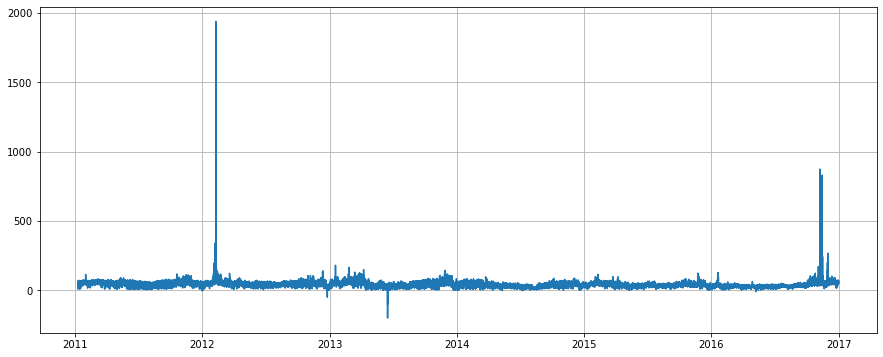

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

Se añaden variables auxiliares

In [7]:
# df['Price_24'] = df.Price.shift(24)
# df['Price_48'] = df.Price.shift(48)
# df['Price_72'] = df.Price.shift(72)
# df['Price_168'] = df.Price.shift(168)

In [8]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [9]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [41]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [10]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [11]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [12]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [13]:
# list(df.columns)

In [14]:
columnas = ['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [15]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['scaler'].append(scaler)
                    dict_new_df['Price_real'].append(row[col])
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [ ]:
dict_new_df = standard_movil(df[columnas])

  7%|█████▎                                                                       | 3648/52416 [02:39<37:41, 21.56it/s]

In [ ]:
df = df.drop(df.head(168).index)

In [ ]:
with open('dict_new_df_fr_epftoolbox_final.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [ ]:
# df = df.drop(df.head(168).index)

In [50]:
# with open('dict_new_df_fr_epftoolbox.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [51]:
df_nuevo = pd.DataFrame(dict_new_df)

In [52]:
for col in columnas_post:
    df_nuevo[col] = df[col].to_numpy()

In [53]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [54]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


# Estandarización móvil + LEAR

In [65]:
with open('dict_new_df_fr_epftoolbox_final.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [66]:
df_nuevo = pd.DataFrame(dict_new_df)

In [67]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [68]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [69]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


In [70]:
df_nuevo = df_nuevo[['Date', 'Price', 'Exogenous 1', 'Exogenous 2']]

In [71]:
df = df_nuevo

In [72]:
df.index = df.Date

In [73]:
df = df.drop(['Date'], axis = 1)

In [74]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [75]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [76]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [77]:
forecast_dates = forecast.index

In [78]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [79]:
calibration_window = 2*364

In [80]:
model = LEAR(calibration_window=calibration_window)

In [81]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [90]:
df_original = pd.read_csv(r"Data\EPFToolbox\FR.csv")

In [91]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [92]:
df_original.index = df_original.Date

In [93]:
df_original = df_original.drop('Date', axis = 1)

In [94]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [95]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [96]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [97]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,39.60,35.48,33.85,45.96,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,23.94,15.69,18.14,20.03,19.23,27.31,34.54,...,32.68,25.25,30.43,43.04,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,23.53,22.92,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,49.97,46.74,44.82,43.42,42.01,45.76,52.87,59.98,67.90,69.14,...,51.27,51.82,54.65,69.99,72.89,72.15,58.60,51.48,51.27,51.48
2016-12-28,48.31,45.76,43.03,40.46,39.34,40.83,44.80,51.00,53.00,56.90,...,50.77,51.60,55.20,63.28,63.70,59.82,62.36,50.00,49.02,47.73
2016-12-29,42.40,39.30,36.83,34.11,34.99,37.64,47.30,51.27,57.42,58.03,...,49.60,51.63,54.43,63.95,67.17,66.40,59.41,51.72,56.44,55.20


In [98]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 11.74%  |  MAE: 4.752
2015-01-02 - sMAPE: 10.19%  |  MAE: 3.915
2015-01-03 - sMAPE: 9.99%  |  MAE: 3.856
2015-01-04 - sMAPE: 10.54%  |  MAE: 3.788
2015-01-05 - sMAPE: 10.28%  |  MAE: 3.887
2015-01-06 - sMAPE: 10.01%  |  MAE: 3.920
2015-01-07 - sMAPE: 9.22%  |  MAE: 3.641
2015-01-08 - sMAPE: 9.06%  |  MAE: 3.594
2015-01-09 - sMAPE: 10.06%  |  MAE: 3.833
2015-01-10 - sMAPE: 12.66%  |  MAE: 4.157
2015-01-11 - sMAPE: 15.22%  |  MAE: 4.491
2015-01-12 - sMAPE: 14.57%  |  MAE: 4.310
2015-01-13 - sMAPE: 14.13%  |  MAE: 4.184
2015-01-14 - sMAPE: 13.90%  |  MAE: 4.157
2015-01-15 - sMAPE: 13.58%  |  MAE: 4.051
2015-01-16 - sMAPE: 13.96%  |  MAE: 4.241
2015-01-17 - sMAPE: 13.76%  |  MAE: 4.215
2015-01-18 - sMAPE: 13.51%  |  MAE: 4.174
2015-01-19 - sMAPE: 13.10%  |  MAE: 4.108
2015-01-20 - sMAPE: 12.62%  |  MAE: 3.986
2015-01-21 - sMAPE: 12.32%  |  MAE: 3.943
2015-01-22 - sMAPE: 12.07%  |  MAE: 3.925
2015-01-23 - sMAPE: 11.77%  |  MAE: 3.869
2015-01-24 - sMAPE: 11.44%  |  MAE: 3

2015-07-17 - sMAPE: 11.69%  |  MAE: 3.980
2015-07-18 - sMAPE: 11.68%  |  MAE: 3.979
2015-07-19 - sMAPE: 11.69%  |  MAE: 3.981
2015-07-20 - sMAPE: 11.66%  |  MAE: 3.974
2015-07-21 - sMAPE: 11.68%  |  MAE: 3.995
2015-07-22 - sMAPE: 11.66%  |  MAE: 3.994
2015-07-23 - sMAPE: 11.64%  |  MAE: 3.991
2015-07-24 - sMAPE: 11.61%  |  MAE: 3.983
2015-07-25 - sMAPE: 11.82%  |  MAE: 4.039
2015-07-26 - sMAPE: 11.93%  |  MAE: 4.040
2015-07-27 - sMAPE: 12.05%  |  MAE: 4.080
2015-07-28 - sMAPE: 12.08%  |  MAE: 4.087
2015-07-29 - sMAPE: 12.07%  |  MAE: 4.082
2015-07-30 - sMAPE: 12.11%  |  MAE: 4.089
2015-07-31 - sMAPE: 12.08%  |  MAE: 4.079
2015-08-01 - sMAPE: 12.12%  |  MAE: 4.083
2015-08-02 - sMAPE: 12.11%  |  MAE: 4.073
2015-08-03 - sMAPE: 12.12%  |  MAE: 4.075
2015-08-04 - sMAPE: 12.13%  |  MAE: 4.078
2015-08-05 - sMAPE: 12.12%  |  MAE: 4.074
2015-08-06 - sMAPE: 12.09%  |  MAE: 4.066
2015-08-07 - sMAPE: 12.06%  |  MAE: 4.056
2015-08-08 - sMAPE: 12.04%  |  MAE: 4.049
2015-08-09 - sMAPE: 12.05%  |  MAE

2016-01-29 - sMAPE: 11.77%  |  MAE: 3.985
2016-01-30 - sMAPE: 11.79%  |  MAE: 3.983
2016-01-31 - sMAPE: 11.82%  |  MAE: 3.982
2016-02-01 - sMAPE: 11.84%  |  MAE: 3.981
2016-02-02 - sMAPE: 11.83%  |  MAE: 3.975
2016-02-03 - sMAPE: 11.83%  |  MAE: 3.972
2016-02-04 - sMAPE: 11.83%  |  MAE: 3.970
2016-02-05 - sMAPE: 11.83%  |  MAE: 3.968
2016-02-06 - sMAPE: 11.83%  |  MAE: 3.963
2016-02-07 - sMAPE: 11.85%  |  MAE: 3.961
2016-02-08 - sMAPE: 11.87%  |  MAE: 3.959
2016-02-09 - sMAPE: 11.86%  |  MAE: 3.954
2016-02-10 - sMAPE: 11.85%  |  MAE: 3.949
2016-02-11 - sMAPE: 11.84%  |  MAE: 3.944
2016-02-12 - sMAPE: 11.83%  |  MAE: 3.941
2016-02-13 - sMAPE: 11.84%  |  MAE: 3.940
2016-02-14 - sMAPE: 11.86%  |  MAE: 3.937
2016-02-15 - sMAPE: 11.85%  |  MAE: 3.933
2016-02-16 - sMAPE: 11.85%  |  MAE: 3.933
2016-02-17 - sMAPE: 11.84%  |  MAE: 3.929
2016-02-18 - sMAPE: 11.83%  |  MAE: 3.925
2016-02-19 - sMAPE: 11.82%  |  MAE: 3.922
2016-02-20 - sMAPE: 11.82%  |  MAE: 3.918
2016-02-21 - sMAPE: 11.89%  |  MAE

2016-08-12 - sMAPE: 11.56%  |  MAE: 3.495
2016-08-13 - sMAPE: 11.56%  |  MAE: 3.493
2016-08-14 - sMAPE: 11.57%  |  MAE: 3.493
2016-08-15 - sMAPE: 11.56%  |  MAE: 3.490
2016-08-16 - sMAPE: 11.55%  |  MAE: 3.486
2016-08-17 - sMAPE: 11.54%  |  MAE: 3.485
2016-08-18 - sMAPE: 11.53%  |  MAE: 3.481
2016-08-19 - sMAPE: 11.53%  |  MAE: 3.480
2016-08-20 - sMAPE: 11.52%  |  MAE: 3.477
2016-08-21 - sMAPE: 11.56%  |  MAE: 3.480
2016-08-22 - sMAPE: 11.55%  |  MAE: 3.477
2016-08-23 - sMAPE: 11.54%  |  MAE: 3.473
2016-08-24 - sMAPE: 11.53%  |  MAE: 3.470
2016-08-25 - sMAPE: 11.52%  |  MAE: 3.467
2016-08-26 - sMAPE: 11.51%  |  MAE: 3.466
2016-08-27 - sMAPE: 11.51%  |  MAE: 3.468
2016-08-28 - sMAPE: 11.51%  |  MAE: 3.467
2016-08-29 - sMAPE: 11.52%  |  MAE: 3.470
2016-08-30 - sMAPE: 11.51%  |  MAE: 3.469
2016-08-31 - sMAPE: 11.50%  |  MAE: 3.467
2016-09-01 - sMAPE: 11.49%  |  MAE: 3.464
2016-09-02 - sMAPE: 11.49%  |  MAE: 3.464
2016-09-03 - sMAPE: 11.48%  |  MAE: 3.463
2016-09-04 - sMAPE: 11.48%  |  MAE

In [99]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.320815,40.829595,38.640634,35.763417,32.277436,29.271777,29.988604,31.243378,32.738284,33.602125,...,33.067586,30.27767,32.736601,41.605098,48.476227,47.527047,43.973135,40.740636,42.896784,42.010699
2015-01-02,41.583362,40.199487,37.712768,34.052143,32.549681,32.22633,35.294039,41.201488,45.011407,46.900623,...,42.188502,39.333998,41.556601,50.048915,52.339689,53.405333,48.316495,45.548934,46.810468,44.325921
2015-01-03,40.350672,37.438686,34.807438,30.447474,27.867141,29.658912,31.806623,34.47542,38.104617,41.08826,...,35.832965,33.187847,34.737912,43.438261,44.059531,45.976874,41.022812,37.574996,41.659111,40.184747
2015-01-04,36.860605,34.756415,32.437841,27.424122,25.346085,27.02858,25.878902,26.726622,30.196761,33.026524,...,32.458257,30.55348,32.613185,42.267923,46.5411,47.900748,44.536158,41.630132,41.539395,40.40572
2015-01-05,38.404001,36.069539,33.284883,27.923556,27.547593,34.244847,43.049509,53.690977,55.746934,56.833653,...,50.79928,49.201539,50.279055,60.840515,64.188785,62.767939,55.421109,51.819953,51.269093,47.681025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,44.603195,40.011299,37.829576,31.981595,29.380081,34.674624,43.228833,55.101738,58.398386,59.254302,...,53.526224,52.531853,54.1616,60.852089,76.654303,68.244154,61.507956,56.844823,56.134913,52.601729
2016-12-28,47.703048,45.116599,43.869959,40.946719,39.14092,41.770847,48.514728,57.83173,62.496638,62.861805,...,53.446567,52.841432,54.634177,63.384147,75.633818,68.930297,60.997136,55.751093,55.220002,52.773662
2016-12-29,45.830427,43.333462,41.438827,38.812169,37.790207,40.524469,49.926076,60.605574,64.260231,63.942209,...,55.983481,56.1096,58.301662,66.938979,82.76716,74.667035,64.969086,57.389389,56.919253,54.591564


In [100]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_2_anos_ventana.csv")

In [101]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [102]:
forecast_dates = forecast.index

In [103]:
calibration_window = 1*364

In [104]:
model = LEAR(calibration_window=calibration_window)

In [105]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 10.39%  |  MAE: 4.247
2015-01-02 - sMAPE: 10.61%  |  MAE: 4.088
2015-01-03 - sMAPE: 10.54%  |  MAE: 4.084
2015-01-04 - sMAPE: 10.58%  |  MAE: 3.918
2015-01-05 - sMAPE: 10.26%  |  MAE: 3.985
2015-01-06 - sMAPE: 10.08%  |  MAE: 4.024
2015-01-07 - sMAPE: 9.17%  |  MAE: 3.690
2015-01-08 - sMAPE: 9.03%  |  MAE: 3.625
2015-01-09 - sMAPE: 9.59%  |  MAE: 3.704
2015-01-10 - sMAPE: 11.14%  |  MAE: 3.809
2015-01-11 - sMAPE: 14.93%  |  MAE: 4.307
2015-01-12 - sMAPE: 14.26%  |  MAE: 4.123
2015-01-13 - sMAPE: 13.87%  |  MAE: 4.014
2015-01-14 - sMAPE: 13.70%  |  MAE: 4.018
2015-01-15 - sMAPE: 13.43%  |  MAE: 3.935
2015-01-16 - sMAPE: 13.98%  |  MAE: 4.172
2015-01-17 - sMAPE: 13.73%  |  MAE: 4.132
2015-01-18 - sMAPE: 13.49%  |  MAE: 4.096
2015-01-19 - sMAPE: 13.13%  |  MAE: 4.055
2015-01-20 - sMAPE: 12.66%  |  MAE: 3.945
2015-01-21 - sMAPE: 12.31%  |  MAE: 3.881
2015-01-22 - sMAPE: 12.07%  |  MAE: 3.873
2015-01-23 - sMAPE: 11.83%  |  MAE: 3.843
2015-01-24 - sMAPE: 11.49%  |  MAE: 3

2015-07-17 - sMAPE: 11.89%  |  MAE: 4.025
2015-07-18 - sMAPE: 11.86%  |  MAE: 4.019
2015-07-19 - sMAPE: 11.87%  |  MAE: 4.023
2015-07-20 - sMAPE: 11.85%  |  MAE: 4.016
2015-07-21 - sMAPE: 11.86%  |  MAE: 4.035
2015-07-22 - sMAPE: 11.84%  |  MAE: 4.032
2015-07-23 - sMAPE: 11.82%  |  MAE: 4.028
2015-07-24 - sMAPE: 11.79%  |  MAE: 4.021
2015-07-25 - sMAPE: 12.01%  |  MAE: 4.082
2015-07-26 - sMAPE: 12.06%  |  MAE: 4.081
2015-07-27 - sMAPE: 12.19%  |  MAE: 4.119
2015-07-28 - sMAPE: 12.23%  |  MAE: 4.130
2015-07-29 - sMAPE: 12.23%  |  MAE: 4.127
2015-07-30 - sMAPE: 12.26%  |  MAE: 4.131
2015-07-31 - sMAPE: 12.25%  |  MAE: 4.124
2015-08-01 - sMAPE: 12.30%  |  MAE: 4.130
2015-08-02 - sMAPE: 12.28%  |  MAE: 4.118
2015-08-03 - sMAPE: 12.31%  |  MAE: 4.123
2015-08-04 - sMAPE: 12.32%  |  MAE: 4.130
2015-08-05 - sMAPE: 12.31%  |  MAE: 4.126
2015-08-06 - sMAPE: 12.29%  |  MAE: 4.119
2015-08-07 - sMAPE: 12.26%  |  MAE: 4.110
2015-08-08 - sMAPE: 12.25%  |  MAE: 4.106
2015-08-09 - sMAPE: 12.24%  |  MAE

2016-01-29 - sMAPE: 12.02%  |  MAE: 4.059
2016-01-30 - sMAPE: 12.04%  |  MAE: 4.060
2016-01-31 - sMAPE: 12.08%  |  MAE: 4.058
2016-02-01 - sMAPE: 12.09%  |  MAE: 4.057
2016-02-02 - sMAPE: 12.09%  |  MAE: 4.050
2016-02-03 - sMAPE: 12.09%  |  MAE: 4.048
2016-02-04 - sMAPE: 12.08%  |  MAE: 4.045
2016-02-05 - sMAPE: 12.09%  |  MAE: 4.043
2016-02-06 - sMAPE: 12.09%  |  MAE: 4.039
2016-02-07 - sMAPE: 12.11%  |  MAE: 4.036
2016-02-08 - sMAPE: 12.12%  |  MAE: 4.033
2016-02-09 - sMAPE: 12.11%  |  MAE: 4.027
2016-02-10 - sMAPE: 12.10%  |  MAE: 4.023
2016-02-11 - sMAPE: 12.09%  |  MAE: 4.017
2016-02-12 - sMAPE: 12.09%  |  MAE: 4.016
2016-02-13 - sMAPE: 12.10%  |  MAE: 4.016
2016-02-14 - sMAPE: 12.12%  |  MAE: 4.012
2016-02-15 - sMAPE: 12.11%  |  MAE: 4.007
2016-02-16 - sMAPE: 12.11%  |  MAE: 4.008
2016-02-17 - sMAPE: 12.11%  |  MAE: 4.006
2016-02-18 - sMAPE: 12.09%  |  MAE: 4.002
2016-02-19 - sMAPE: 12.08%  |  MAE: 3.998
2016-02-20 - sMAPE: 12.08%  |  MAE: 3.995
2016-02-21 - sMAPE: 12.16%  |  MAE

2016-08-12 - sMAPE: 11.83%  |  MAE: 3.567
2016-08-13 - sMAPE: 11.83%  |  MAE: 3.564
2016-08-14 - sMAPE: 11.83%  |  MAE: 3.563
2016-08-15 - sMAPE: 11.83%  |  MAE: 3.561
2016-08-16 - sMAPE: 11.81%  |  MAE: 3.557
2016-08-17 - sMAPE: 11.81%  |  MAE: 3.556
2016-08-18 - sMAPE: 11.80%  |  MAE: 3.553
2016-08-19 - sMAPE: 11.79%  |  MAE: 3.552
2016-08-20 - sMAPE: 11.78%  |  MAE: 3.549
2016-08-21 - sMAPE: 11.83%  |  MAE: 3.552
2016-08-22 - sMAPE: 11.81%  |  MAE: 3.549
2016-08-23 - sMAPE: 11.80%  |  MAE: 3.545
2016-08-24 - sMAPE: 11.79%  |  MAE: 3.542
2016-08-25 - sMAPE: 11.78%  |  MAE: 3.540
2016-08-26 - sMAPE: 11.77%  |  MAE: 3.538
2016-08-27 - sMAPE: 11.79%  |  MAE: 3.541
2016-08-28 - sMAPE: 11.78%  |  MAE: 3.541
2016-08-29 - sMAPE: 11.79%  |  MAE: 3.545
2016-08-30 - sMAPE: 11.78%  |  MAE: 3.543
2016-08-31 - sMAPE: 11.77%  |  MAE: 3.541
2016-09-01 - sMAPE: 11.76%  |  MAE: 3.538
2016-09-02 - sMAPE: 11.76%  |  MAE: 3.538
2016-09-03 - sMAPE: 11.75%  |  MAE: 3.536
2016-09-04 - sMAPE: 11.75%  |  MAE

In [106]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,44.510758,42.107673,41.379678,37.18,34.750036,32.419835,26.097444,31.069248,32.742857,34.053785,...,32.9367,32.459944,35.310057,41.482897,46.380704,46.669882,44.234586,41.358857,43.185733,42.825833
2015-01-02,43.514964,42.642458,41.206967,35.563554,33.254907,36.238895,36.213717,41.829307,44.375993,46.739603,...,43.683527,42.196927,44.600029,49.796641,51.712755,52.634086,48.530273,45.025907,46.745378,43.215179
2015-01-03,40.798049,37.434269,34.736032,30.971159,28.406596,29.531942,30.776625,35.06066,37.761606,41.099541,...,35.61479,34.551623,36.84264,41.962113,46.34689,44.924591,40.629955,36.815003,40.690307,39.110974
2015-01-04,35.835534,32.219746,28.849402,21.077527,18.601161,21.454768,24.554861,25.93916,29.216349,32.021105,...,31.043355,31.025736,33.592987,40.124794,45.041853,45.795929,44.576973,41.149938,41.32906,39.608406
2015-01-05,39.085406,35.834497,32.551178,27.245817,25.245043,33.861061,43.340242,53.286965,55.251111,55.509435,...,51.611589,50.430142,52.621293,60.17421,62.78612,64.12942,58.00337,51.845017,51.484085,46.924082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,45.471256,40.70979,38.38602,35.186013,31.847764,36.93268,46.538045,56.703475,59.915851,60.973949,...,55.381439,53.730185,52.82043,58.923169,82.636722,70.753665,62.679237,57.659636,56.298085,52.628994
2016-12-28,47.809451,45.465548,44.476913,42.58506,41.203666,44.17704,51.502639,59.670779,63.046167,63.96929,...,55.069483,54.248056,55.522603,61.067614,78.644282,69.634507,62.048346,55.516428,55.980116,52.144161
2016-12-29,46.051375,42.989991,40.595275,38.579132,37.948677,40.024002,49.638219,58.15808,61.475046,63.099003,...,55.55365,55.397745,57.916618,63.565989,85.289686,75.925612,66.324239,58.240581,58.334923,55.15395


In [107]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_1_ano_ventana.csv")

In [108]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [109]:
forecast_dates = forecast.index

In [110]:
calibration_window = 182

In [111]:
model = LEAR(calibration_window=calibration_window)

In [112]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 10.34%  |  MAE: 4.183
2015-01-02 - sMAPE: 9.75%  |  MAE: 3.753
2015-01-03 - sMAPE: 10.63%  |  MAE: 4.099
2015-01-04 - sMAPE: 10.65%  |  MAE: 3.878
2015-01-05 - sMAPE: 9.93%  |  MAE: 3.735
2015-01-06 - sMAPE: 9.65%  |  MAE: 3.740
2015-01-07 - sMAPE: 8.80%  |  MAE: 3.439
2015-01-08 - sMAPE: 8.48%  |  MAE: 3.317
2015-01-09 - sMAPE: 9.17%  |  MAE: 3.468
2015-01-10 - sMAPE: 11.22%  |  MAE: 3.714
2015-01-11 - sMAPE: 14.79%  |  MAE: 4.209
2015-01-12 - sMAPE: 14.21%  |  MAE: 4.058
2015-01-13 - sMAPE: 13.78%  |  MAE: 3.960
2015-01-14 - sMAPE: 13.72%  |  MAE: 4.009
2015-01-15 - sMAPE: 13.46%  |  MAE: 3.941
2015-01-16 - sMAPE: 14.10%  |  MAE: 4.205
2015-01-17 - sMAPE: 13.85%  |  MAE: 4.163
2015-01-18 - sMAPE: 13.61%  |  MAE: 4.132
2015-01-19 - sMAPE: 13.12%  |  MAE: 4.024
2015-01-20 - sMAPE: 12.64%  |  MAE: 3.912
2015-01-21 - sMAPE: 12.31%  |  MAE: 3.858
2015-01-22 - sMAPE: 12.10%  |  MAE: 3.867
2015-01-23 - sMAPE: 11.81%  |  MAE: 3.813
2015-01-24 - sMAPE: 11.49%  |  MAE: 3.72

2015-07-17 - sMAPE: 12.12%  |  MAE: 4.104
2015-07-18 - sMAPE: 12.09%  |  MAE: 4.098
2015-07-19 - sMAPE: 12.09%  |  MAE: 4.096
2015-07-20 - sMAPE: 12.06%  |  MAE: 4.086
2015-07-21 - sMAPE: 12.07%  |  MAE: 4.104
2015-07-22 - sMAPE: 12.05%  |  MAE: 4.101
2015-07-23 - sMAPE: 12.02%  |  MAE: 4.096
2015-07-24 - sMAPE: 12.00%  |  MAE: 4.090
2015-07-25 - sMAPE: 12.24%  |  MAE: 4.157
2015-07-26 - sMAPE: 12.39%  |  MAE: 4.181
2015-07-27 - sMAPE: 12.52%  |  MAE: 4.226
2015-07-28 - sMAPE: 12.60%  |  MAE: 4.254
2015-07-29 - sMAPE: 12.61%  |  MAE: 4.257
2015-07-30 - sMAPE: 12.62%  |  MAE: 4.257
2015-07-31 - sMAPE: 12.60%  |  MAE: 4.251
2015-08-01 - sMAPE: 12.67%  |  MAE: 4.259
2015-08-02 - sMAPE: 12.64%  |  MAE: 4.245
2015-08-03 - sMAPE: 12.67%  |  MAE: 4.252
2015-08-04 - sMAPE: 12.71%  |  MAE: 4.266
2015-08-05 - sMAPE: 12.70%  |  MAE: 4.265
2015-08-06 - sMAPE: 12.69%  |  MAE: 4.261
2015-08-07 - sMAPE: 12.66%  |  MAE: 4.253
2015-08-08 - sMAPE: 12.64%  |  MAE: 4.245
2015-08-09 - sMAPE: 12.64%  |  MAE

2016-01-29 - sMAPE: 12.48%  |  MAE: 4.230
2016-01-30 - sMAPE: 12.50%  |  MAE: 4.230
2016-01-31 - sMAPE: 12.52%  |  MAE: 4.226
2016-02-01 - sMAPE: 12.53%  |  MAE: 4.224
2016-02-02 - sMAPE: 12.53%  |  MAE: 4.216
2016-02-03 - sMAPE: 12.52%  |  MAE: 4.213
2016-02-04 - sMAPE: 12.52%  |  MAE: 4.209
2016-02-05 - sMAPE: 12.52%  |  MAE: 4.207
2016-02-06 - sMAPE: 12.51%  |  MAE: 4.202
2016-02-07 - sMAPE: 12.54%  |  MAE: 4.199
2016-02-08 - sMAPE: 12.53%  |  MAE: 4.192
2016-02-09 - sMAPE: 12.53%  |  MAE: 4.187
2016-02-10 - sMAPE: 12.52%  |  MAE: 4.183
2016-02-11 - sMAPE: 12.51%  |  MAE: 4.178
2016-02-12 - sMAPE: 12.51%  |  MAE: 4.176
2016-02-13 - sMAPE: 12.51%  |  MAE: 4.173
2016-02-14 - sMAPE: 12.53%  |  MAE: 4.171
2016-02-15 - sMAPE: 12.53%  |  MAE: 4.166
2016-02-16 - sMAPE: 12.53%  |  MAE: 4.166
2016-02-17 - sMAPE: 12.53%  |  MAE: 4.166
2016-02-18 - sMAPE: 12.51%  |  MAE: 4.160
2016-02-19 - sMAPE: 12.50%  |  MAE: 4.156
2016-02-20 - sMAPE: 12.49%  |  MAE: 4.151
2016-02-21 - sMAPE: 12.52%  |  MAE

2016-08-12 - sMAPE: 12.13%  |  MAE: 3.694
2016-08-13 - sMAPE: 12.12%  |  MAE: 3.689
2016-08-14 - sMAPE: 12.12%  |  MAE: 3.688
2016-08-15 - sMAPE: 12.12%  |  MAE: 3.687
2016-08-16 - sMAPE: 12.11%  |  MAE: 3.683
2016-08-17 - sMAPE: 12.10%  |  MAE: 3.682
2016-08-18 - sMAPE: 12.09%  |  MAE: 3.679
2016-08-19 - sMAPE: 12.09%  |  MAE: 3.677
2016-08-20 - sMAPE: 12.08%  |  MAE: 3.674
2016-08-21 - sMAPE: 12.11%  |  MAE: 3.675
2016-08-22 - sMAPE: 12.10%  |  MAE: 3.672
2016-08-23 - sMAPE: 12.09%  |  MAE: 3.669
2016-08-24 - sMAPE: 12.08%  |  MAE: 3.667
2016-08-25 - sMAPE: 12.07%  |  MAE: 3.664
2016-08-26 - sMAPE: 12.06%  |  MAE: 3.663
2016-08-27 - sMAPE: 12.07%  |  MAE: 3.666
2016-08-28 - sMAPE: 12.07%  |  MAE: 3.665
2016-08-29 - sMAPE: 12.07%  |  MAE: 3.668
2016-08-30 - sMAPE: 12.07%  |  MAE: 3.667
2016-08-31 - sMAPE: 12.06%  |  MAE: 3.665
2016-09-01 - sMAPE: 12.05%  |  MAE: 3.661
2016-09-02 - sMAPE: 12.04%  |  MAE: 3.661
2016-09-03 - sMAPE: 12.04%  |  MAE: 3.660
2016-09-04 - sMAPE: 12.03%  |  MAE

In [113]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,44.179005,40.424647,43.043284,35.92658,35.675354,32.279916,26.46475,30.322276,32.102829,33.716816,...,31.949492,31.40039,35.517824,37.63704,47.451697,48.098928,44.505457,43.0924,45.101924,43.520817
2015-01-02,42.65159,39.159471,39.319157,33.497692,32.341963,34.086758,34.712526,38.62269,41.324205,45.503241,...,41.632031,40.473167,43.789145,48.630265,53.867367,48.581025,44.011052,43.384142,45.490288,42.779994
2015-01-03,40.960869,37.100721,34.964009,30.116986,28.365276,27.419424,29.702457,32.98302,36.462647,38.825725,...,35.668372,34.494571,37.312219,43.175705,46.244902,43.772025,37.887724,37.437263,40.554165,38.672309
2015-01-04,36.928824,33.322231,29.683539,24.338595,24.279605,22.347396,24.487249,27.278584,30.759341,33.306819,...,31.416367,30.603036,33.237244,40.034067,47.305203,47.998014,45.17932,43.217442,43.798223,41.730867
2015-01-05,38.321377,34.315203,32.278184,26.568639,26.389202,32.551171,42.990579,50.298481,52.889029,51.845787,...,51.587936,50.053796,53.028124,60.23371,62.945828,57.700796,54.840767,49.806594,49.303906,47.172122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,46.449435,38.892288,37.310456,31.871791,28.347886,33.138571,46.074854,53.093198,58.189247,59.156432,...,54.82746,54.069765,57.322038,64.984882,89.00302,79.479125,64.957116,60.066131,57.411135,52.192682
2016-12-28,47.614831,45.966402,45.698754,44.212219,40.88685,43.942099,50.976944,68.772771,64.398981,68.947283,...,55.877054,55.462212,56.877534,65.78423,88.502085,73.728637,63.732138,58.612425,55.709345,51.090077
2016-12-29,45.677481,43.040988,40.821742,38.562239,36.278791,40.121271,47.497459,50.50719,56.871322,57.89162,...,56.862462,56.742429,58.980504,66.420819,96.512958,78.462009,66.826547,58.115154,55.638986,51.708711


In [114]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_6_meses_ventana.csv")

In [115]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [116]:
forecast_dates = forecast.index

In [117]:
calibration_window = None

In [118]:
model = LEAR(calibration_window=calibration_window)

In [119]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 12.50%  |  MAE: 4.922
2015-01-02 - sMAPE: 10.51%  |  MAE: 3.989
2015-01-03 - sMAPE: 9.93%  |  MAE: 3.787
2015-01-04 - sMAPE: 10.57%  |  MAE: 3.768
2015-01-05 - sMAPE: 10.13%  |  MAE: 3.793
2015-01-06 - sMAPE: 9.93%  |  MAE: 3.857
2015-01-07 - sMAPE: 9.22%  |  MAE: 3.625
2015-01-08 - sMAPE: 8.97%  |  MAE: 3.537
2015-01-09 - sMAPE: 10.15%  |  MAE: 3.858
2015-01-10 - sMAPE: 13.15%  |  MAE: 4.301
2015-01-11 - sMAPE: 15.80%  |  MAE: 4.577
2015-01-12 - sMAPE: 14.96%  |  MAE: 4.345
2015-01-13 - sMAPE: 14.51%  |  MAE: 4.228
2015-01-14 - sMAPE: 14.23%  |  MAE: 4.186
2015-01-15 - sMAPE: 13.86%  |  MAE: 4.070
2015-01-16 - sMAPE: 14.14%  |  MAE: 4.227
2015-01-17 - sMAPE: 13.87%  |  MAE: 4.176
2015-01-18 - sMAPE: 13.58%  |  MAE: 4.125
2015-01-19 - sMAPE: 13.19%  |  MAE: 4.072
2015-01-20 - sMAPE: 12.68%  |  MAE: 3.940
2015-01-21 - sMAPE: 12.31%  |  MAE: 3.865
2015-01-22 - sMAPE: 12.00%  |  MAE: 3.817
2015-01-23 - sMAPE: 11.68%  |  MAE: 3.751
2015-01-24 - sMAPE: 11.39%  |  MAE: 3.

2015-07-17 - sMAPE: 11.72%  |  MAE: 4.001
2015-07-18 - sMAPE: 11.72%  |  MAE: 4.000
2015-07-19 - sMAPE: 11.73%  |  MAE: 4.003
2015-07-20 - sMAPE: 11.70%  |  MAE: 3.995
2015-07-21 - sMAPE: 11.72%  |  MAE: 4.014
2015-07-22 - sMAPE: 11.70%  |  MAE: 4.011
2015-07-23 - sMAPE: 11.67%  |  MAE: 4.009
2015-07-24 - sMAPE: 11.64%  |  MAE: 4.001
2015-07-25 - sMAPE: 11.88%  |  MAE: 4.065
2015-07-26 - sMAPE: 11.99%  |  MAE: 4.071
2015-07-27 - sMAPE: 12.12%  |  MAE: 4.113
2015-07-28 - sMAPE: 12.16%  |  MAE: 4.123
2015-07-29 - sMAPE: 12.16%  |  MAE: 4.119
2015-07-30 - sMAPE: 12.19%  |  MAE: 4.125
2015-07-31 - sMAPE: 12.18%  |  MAE: 4.118
2015-08-01 - sMAPE: 12.22%  |  MAE: 4.122
2015-08-02 - sMAPE: 12.20%  |  MAE: 4.110
2015-08-03 - sMAPE: 12.22%  |  MAE: 4.114
2015-08-04 - sMAPE: 12.25%  |  MAE: 4.124
2015-08-05 - sMAPE: 12.24%  |  MAE: 4.121
2015-08-06 - sMAPE: 12.21%  |  MAE: 4.115
2015-08-07 - sMAPE: 12.19%  |  MAE: 4.106
2015-08-08 - sMAPE: 12.17%  |  MAE: 4.100
2015-08-09 - sMAPE: 12.17%  |  MAE

2016-01-29 - sMAPE: 11.83%  |  MAE: 4.025
2016-01-30 - sMAPE: 11.85%  |  MAE: 4.025
2016-01-31 - sMAPE: 11.88%  |  MAE: 4.022
2016-02-01 - sMAPE: 11.89%  |  MAE: 4.020
2016-02-02 - sMAPE: 11.89%  |  MAE: 4.014
2016-02-03 - sMAPE: 11.89%  |  MAE: 4.011
2016-02-04 - sMAPE: 11.88%  |  MAE: 4.007
2016-02-05 - sMAPE: 11.88%  |  MAE: 4.004
2016-02-06 - sMAPE: 11.88%  |  MAE: 4.000
2016-02-07 - sMAPE: 11.90%  |  MAE: 3.997
2016-02-08 - sMAPE: 11.91%  |  MAE: 3.995
2016-02-09 - sMAPE: 11.90%  |  MAE: 3.990
2016-02-10 - sMAPE: 11.90%  |  MAE: 3.985
2016-02-11 - sMAPE: 11.88%  |  MAE: 3.980
2016-02-12 - sMAPE: 11.88%  |  MAE: 3.978
2016-02-13 - sMAPE: 11.88%  |  MAE: 3.975
2016-02-14 - sMAPE: 11.90%  |  MAE: 3.972
2016-02-15 - sMAPE: 11.90%  |  MAE: 3.969
2016-02-16 - sMAPE: 11.90%  |  MAE: 3.969
2016-02-17 - sMAPE: 11.89%  |  MAE: 3.967
2016-02-18 - sMAPE: 11.88%  |  MAE: 3.962
2016-02-19 - sMAPE: 11.87%  |  MAE: 3.959
2016-02-20 - sMAPE: 11.88%  |  MAE: 3.958
2016-02-21 - sMAPE: 11.91%  |  MAE

2016-08-12 - sMAPE: 11.64%  |  MAE: 3.533
2016-08-13 - sMAPE: 11.64%  |  MAE: 3.531
2016-08-14 - sMAPE: 11.64%  |  MAE: 3.530
2016-08-15 - sMAPE: 11.63%  |  MAE: 3.527
2016-08-16 - sMAPE: 11.62%  |  MAE: 3.523
2016-08-17 - sMAPE: 11.62%  |  MAE: 3.522
2016-08-18 - sMAPE: 11.60%  |  MAE: 3.518
2016-08-19 - sMAPE: 11.60%  |  MAE: 3.517
2016-08-20 - sMAPE: 11.59%  |  MAE: 3.514
2016-08-21 - sMAPE: 11.64%  |  MAE: 3.519
2016-08-22 - sMAPE: 11.63%  |  MAE: 3.516
2016-08-23 - sMAPE: 11.62%  |  MAE: 3.511
2016-08-24 - sMAPE: 11.60%  |  MAE: 3.508
2016-08-25 - sMAPE: 11.59%  |  MAE: 3.505
2016-08-26 - sMAPE: 11.58%  |  MAE: 3.503
2016-08-27 - sMAPE: 11.59%  |  MAE: 3.504
2016-08-28 - sMAPE: 11.59%  |  MAE: 3.503
2016-08-29 - sMAPE: 11.59%  |  MAE: 3.506
2016-08-30 - sMAPE: 11.58%  |  MAE: 3.505
2016-08-31 - sMAPE: 11.57%  |  MAE: 3.502
2016-09-01 - sMAPE: 11.56%  |  MAE: 3.499
2016-09-02 - sMAPE: 11.56%  |  MAE: 3.499
2016-09-03 - sMAPE: 11.55%  |  MAE: 3.497
2016-09-04 - sMAPE: 11.54%  |  MAE

In [120]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.809929,39.845719,38.058756,33.256612,31.178803,29.216641,28.364658,30.320713,32.510961,37.341213,...,31.387743,30.967803,33.359155,41.598679,48.651258,50.63337,45.240611,41.67305,45.40115,42.704568
2015-01-02,42.136719,38.953478,37.219182,33.707789,32.85798,32.727413,34.526605,39.996524,44.375526,46.340548,...,42.736198,40.757141,41.557618,48.54111,55.908259,54.409112,47.663178,44.875113,46.588967,44.086439
2015-01-03,40.260332,36.830054,33.745206,29.830205,28.338044,29.356802,31.170502,34.503102,38.798507,41.686954,...,37.616533,34.915393,35.166481,44.345916,48.098218,45.995825,41.677933,38.543489,42.811823,40.985689
2015-01-04,37.523354,35.441723,32.698377,29.655878,27.433986,26.814407,24.411315,24.599911,28.794573,33.771663,...,31.193858,30.490124,31.294344,40.191149,49.005725,46.821986,44.502646,41.423642,42.849769,40.386243
2015-01-05,37.475803,35.179647,31.867192,28.056546,27.989903,33.600155,42.905689,52.656079,54.798613,54.7168,...,50.484677,49.301731,49.610484,59.675908,67.743589,65.138986,56.921393,49.700595,50.075376,46.598221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,44.67204,41.134628,37.919461,31.021477,28.7133,35.498487,45.405543,54.592778,59.166829,60.102287,...,52.179609,51.291189,53.496575,62.685882,70.341036,66.035471,59.850839,54.825779,55.404644,50.811419
2016-12-28,47.664194,45.558347,43.734703,40.212271,38.884842,42.133916,48.751555,56.904631,60.381666,61.534568,...,52.748321,52.392363,54.068612,64.09634,71.109319,67.247056,60.047601,55.077389,55.046153,52.378747
2016-12-29,45.432219,43.820246,41.642391,38.6537,38.08902,41.713463,48.799677,57.88167,62.0319,64.24944,...,54.293811,54.870183,56.864151,66.845841,75.097607,71.345026,62.497297,56.832105,56.957836,54.354514


In [121]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_sin_ventana.csv")